# 200812 Fastq kmer search stats

In [1]:
using DataFrames
using HDF5
using StatsBase
using Printf
using CSV

In [2]:
using Midas.Kmers

In [3]:
using PyPlot, PyCall
sns = pyimport("seaborn")

PyObject <module 'seaborn' from '/Users/student/anaconda/envs/modeling/lib/python3.6/site-packages/seaborn/__init__.py'>

## Configuration and directories

In [4]:
tmpdir = "tmp/"

"tmp/"

In [5]:
outdir = "../../data/processed/200811-fastq-kmer-counts/"
isdir(outdir) || mkdir(outdir);

## Defs

In [6]:
# Histogram with transparency fill
function myhist(ax, x, color; alpha=.25, lw=2, kw...)
    h1 = ax.hist(x; fc=color, alpha=alpha, kw...)
    h2 = ax.hist(x; histtype=:step, ec=color, lw=lw, kw...)
    return (h1, h2)
end

myhist (generic function with 1 method)

In [7]:
# Histogram with one bin per integer
function counts_hist(ax::PyObject, data::AbstractVector, range=1:maximum(data); kw...)
    cnts = counts(data, range)
    b = ax.bar(range, cnts; kw...)
    ax.set_xticks(range)
    return b
end

counts_hist(data::AbstractVector, range=1:maximum(data); kw...) = counts_hist(plt.gca(), data, range; kw...)

counts_hist (generic function with 4 methods)

In [8]:
megabase_tick_formatter = let
    ticker = pyimport("matplotlib.ticker")
    ticker.FuncFormatter((x, pos) -> @sprintf("%.1f Mb", x/1e6))
end

PyObject <matplotlib.ticker.FuncFormatter object at 0x12f8a99e8>

## Calculate statistics

In [9]:
datafiles = Dict(split(basename(f), '.')[1] => f for f in readdir(tmpdir, join=true) if endswith(f, ".h5"))
length(datafiles)

80

In [10]:
stats_df = let
    rows = map([(k, v) for (k, v) in pairs(datafiles) if isfile(v)]) do (key, file)
        h5 = h5open(file)
        assm_lengths = read(h5, "assembly/contig_lengths")
        assm_cnts = read(h5, "assembly/counts")
        raw_cnts = read(h5, "raw/counts")
        raw_nreads = read(attrs(h5["raw"]), "nreads")
        raw_meanlen = read(attrs(h5["raw"]), "mean_read_length")
        
        return (
            genome=key,
            assm_total_size=sum(assm_lengths),
            assm_ncontigs=length(assm_lengths),
            assm_nkmers=length(assm_cnts),
            assm_kmers_per_kb=length(assm_cnts) / sum(assm_lengths) * 1000,
            assm_frac_singletons=count(==(1), assm_cnts) / length(assm_cnts),
            assm_max_kmer_count=maximum(assm_cnts),
            raw_nreads=raw_nreads,
            raw_mean_read_len=raw_meanlen,
            raw_est_coverage=raw_nreads * raw_meanlen / sum(assm_lengths),
            raw_nkmers=size(raw_cnts, 2),
        )
    end
    
    DataFrame(rows)
end;

show(stats_df, allcols=true)

80×11 DataFrame
│ Row │ genome                         │ assm_total_size │ assm_ncontigs │
│     │ SubString{String}              │ Int64           │ Int64         │
├─────┼────────────────────────────────┼─────────────────┼───────────────┤
│ 1   │ 18AC0012151B1_S7_L001_R1_001   │ 3261293         │ 508           │
│ 2   │ 19AC0015931_S8_L001_R1_001     │ 4990629         │ 723           │
│ 3   │ 17AC0003894N_S2_L001_R1_001    │ 1774211         │ 144           │
│ 4   │ 19AC0011209PEA_S8_L001_R1_001  │ 3478657         │ 4652          │
│ 5   │ 18AC0002827_S7_L001_R1_001     │ 4999553         │ 1476          │
│ 6   │ 18AC0018937_S7_L001_R1_001     │ 2109915         │ 204           │
│ 7   │ 19AC0016711_S11_L001_R1_001    │ 2563002         │ 243           │
│ 8   │ 18AC0018936-2_S13_L001_R1_001  │ 2443962         │ 1498          │
│ 9   │ 18AC0002828_S12_L001_R1_001    │ 2872009         │ 207           │
│ 10  │ 17AC0003892A_S1_L001_R1_001    │ 6419023         │ 2553          │
⋮
│ 70  │

In [11]:
open(joinpath(outdir, "200812-fastq-kmer-statistics.csv"), "w") do f
    CSV.write(f, stats_df)
end

IOStream(<file ../../data/processed/200811-fastq-kmer-counts/200812-fastq-kmer-statistics.csv>)

## Plots

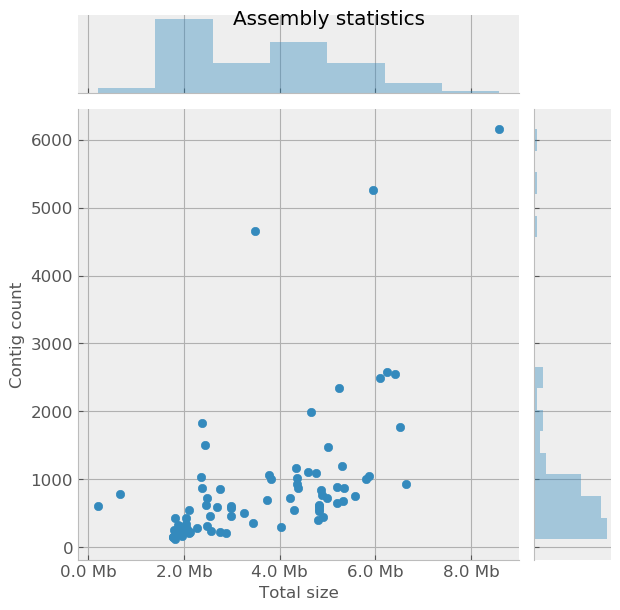

PyObject Text(0.5, 0.98, 'Assembly statistics')

In [12]:
let
    ticker = pyimport("matplotlib.ticker")
    jg = sns.jointplot(stats_df[!, :assm_total_size], stats_df[!, :assm_ncontigs])
    jg.ax_joint.xaxis.set_major_formatter(megabase_tick_formatter)
    jg.ax_joint.set_xlabel("Total size")
    jg.ax_joint.set_ylabel("Contig count")
    plt.suptitle("Assembly statistics")
end

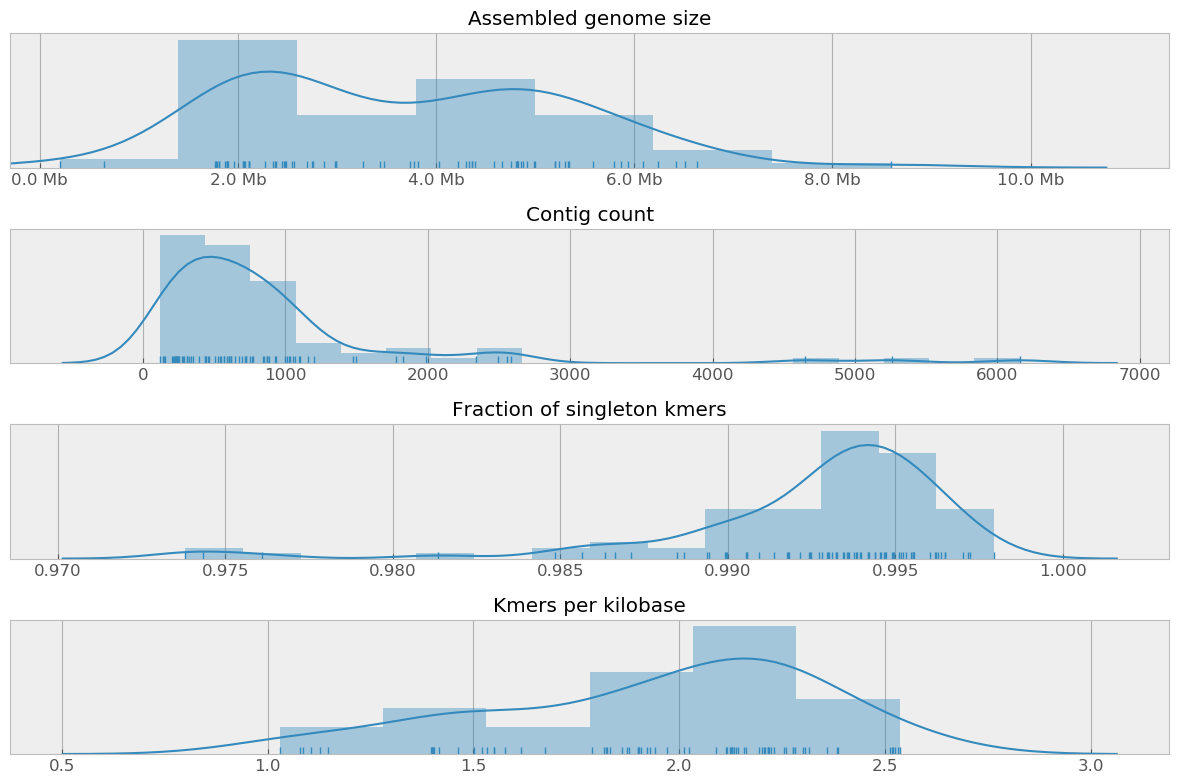

In [13]:
let
    fig, axs = plt.subplots(4, 1, figsize=(12, 8))
#     fig.suptitle("Assembly Statistics", y=1.02)
    
    let ax = axs[1]
        sns.distplot(stats_df[!, :assm_total_size], ax=ax, rug=true)
        ax.set_title("Assembled genome size")
        ax.yaxis.set_visible(false)
        ax.xaxis.set_major_formatter(megabase_tick_formatter)
        ax.set_xlim(-3e5, nothing)
    end
    
    let ax = axs[2]
        sns.distplot(stats_df[!, :assm_ncontigs], ax=ax, rug=true)
        ax.set_title("Contig count")
        ax.yaxis.set_visible(false)
    end
    
    let ax = axs[3]
        sns.distplot(stats_df[!, :assm_frac_singletons], ax=ax, rug=true)
        ax.set_title("Fraction of singleton kmers")
        ax.yaxis.set_visible(false)
    end
    
    let ax = axs[4]
        sns.distplot(stats_df[!, :assm_kmers_per_kb], rug=true, ax=ax)
        ax.set_title("Kmers per kilobase")
        ax.yaxis.set_visible(false)
    end
    
    plt.tight_layout()
end

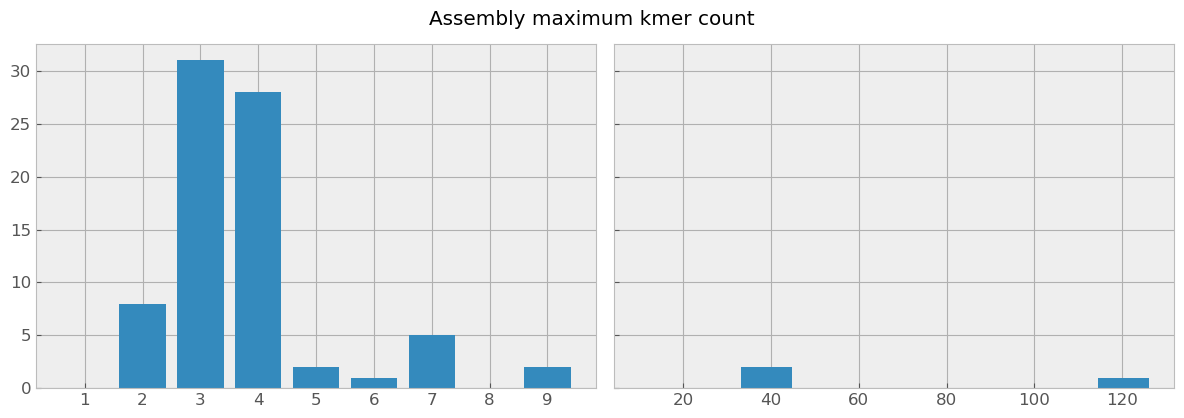

PyObject Text(0.5, 1.04, 'Assembly maximum kmer count')

In [14]:
let
    data = stats_df[!, :assm_max_kmer_count]
    fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharey=true)
    counts_hist(axs[1], data, 1:9)
    axs[2].hist(data, range=(10, maximum(data)))
    plt.tight_layout()
    plt.suptitle("Assembly maximum kmer count", y=1.04)
end

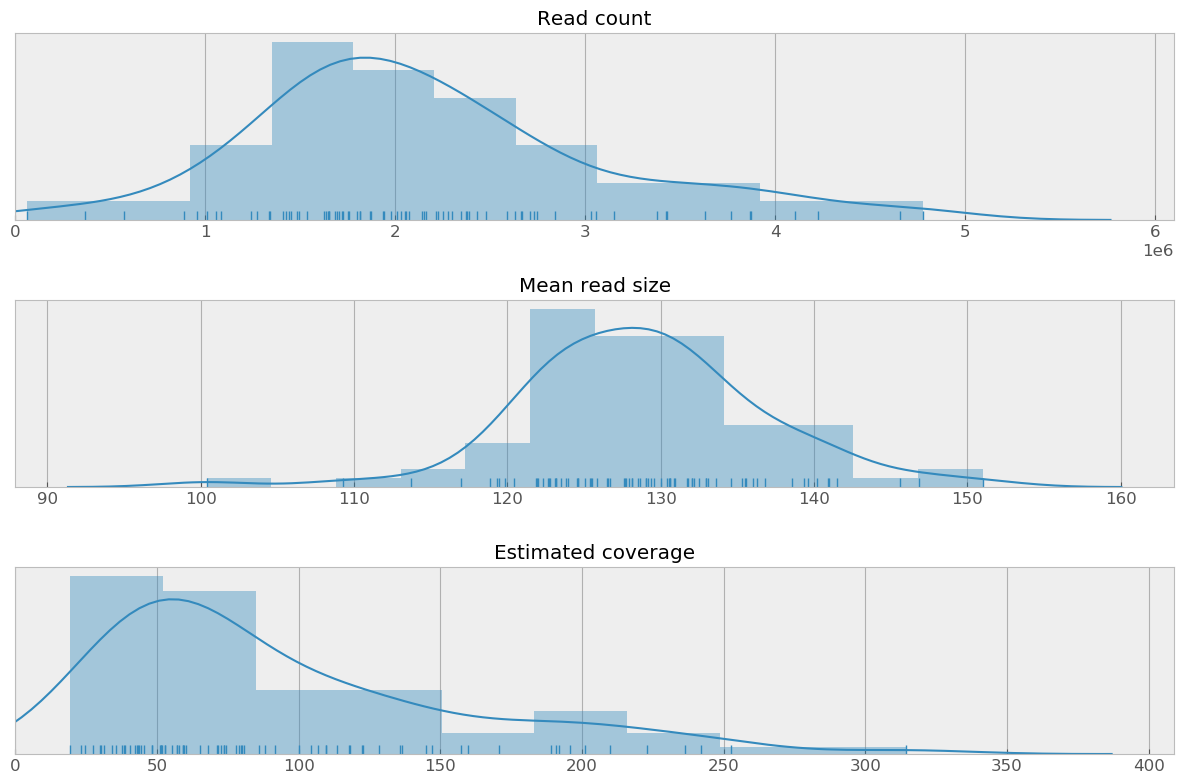

In [15]:
let
    fig, axs = plt.subplots(3, 1, figsize=(12, 8))

    let ax = axs[1]
        sns.distplot(stats_df[!, :raw_nreads], rug=true, ax=ax)
        ax.ticklabel_format(axis=:x, style=:sci, scilimits=(0, 0))
        ax.set_title("Read count")
        ax.set_xlim(0, nothing)
        ax.yaxis.set_visible(false)
    end
    
    let ax = axs[2]
        sns.distplot(stats_df[!, :raw_mean_read_len], rug=true, ax=ax)
        ax.set_title("Mean read size")
        ax.yaxis.set_visible(false)
    end
    
    let ax = axs[3]
        sns.distplot(stats_df[!, :raw_est_coverage], rug=true, ax=ax)
        ax.set_title("Estimated coverage")
        ax.set_xlim(0, nothing)
        ax.yaxis.set_visible(false)
    end
    
    plt.tight_layout()
end

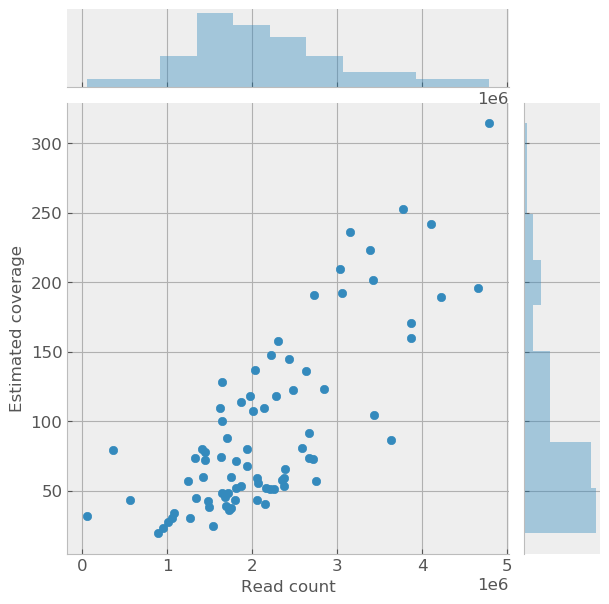

PyObject Text(25.0, 0.5, 'Estimated coverage')

In [16]:
let
    jp = sns.jointplot(stats_df[!, :raw_nreads], stats_df[!, :raw_est_coverage])
    jp.ax_joint.ticklabel_format(style=:sci, scilimits=(0, 4))
    jp.ax_joint.set_xlabel("Read count")
    jp.ax_joint.set_ylabel("Estimated coverage")
end

## Examine outliers

### Assembly genome size

Two are significantly smaller than the rest, under 2 megabases:

In [17]:
show(stats_df[partialsortperm(stats_df[!, :assm_total_size], 1:4), :], allcols=true)

4×11 DataFrame
│ Row │ genome                        │ assm_total_size │ assm_ncontigs │
│     │ SubString{String}             │ Int64           │ Int64         │
├─────┼───────────────────────────────┼─────────────────┼───────────────┤
│ 1   │ 18AC0018936-1_S12_L001_R1_001 │ 200285          │ 604           │
│ 2   │ 19AC0002349B1_S10_L001_R1_001 │ 653490          │ 775           │
│ 3   │ 18AC0017656_S1_L001_R1_001    │ 1768110         │ 143           │
│ 4   │ 17AC0003894N_S2_L001_R1_001   │ 1774211         │ 144           │

│ Row │ assm_nkmers │ assm_kmers_per_kb │ assm_frac_singletons │
│     │ Int64       │ Float64           │ Float64              │
├─────┼─────────────┼───────────────────┼──────────────────────┤
│ 1   │ 375         │ 1.87233           │ 0.981333             │
│ 2   │ 673         │ 1.02986           │ 0.986627             │
│ 3   │ 2476        │ 1.40037           │ 0.997173             │
│ 4   │ 2478        │ 1.39668           │ 0.995561             │

│ Row │ as

In the previous experiment (`200801-gold-standard-queries`) these two didn't have a good match in the database.

Both of these also have a very low kmer count, the count per kilobase is also low but they are not particularly outliers compared to the rest. They also have a pretty low estimated coverage.

### Maximum kmer count

The maximum kmer count for most genomes is < 10, but a few have at least one kmer that occurs much more often. See what's up with these.

In [18]:
show(stats_df[partialsortperm(stats_df[!, :assm_max_kmer_count], 1:4, rev=true), :], allcols=true)

4×11 DataFrame
│ Row │ genome                      │ assm_total_size │ assm_ncontigs │
│     │ SubString{String}           │ Int64           │ Int64         │
├─────┼─────────────────────────────┼─────────────────┼───────────────┤
│ 1   │ 19AC0002350_S7_L001_R1_001  │ 4586503         │ 1099          │
│ 2   │ 19AC0015929_S6_L001_R1_001  │ 4363684         │ 1023          │
│ 3   │ 18AC0017658_S3_L001_R1_001  │ 4362125         │ 927           │
│ 4   │ 19AC0016711_S11_L001_R1_001 │ 2563002         │ 243           │

│ Row │ assm_nkmers │ assm_kmers_per_kb │ assm_frac_singletons │
│     │ Int64       │ Float64           │ Float64              │
├─────┼─────────────┼───────────────────┼──────────────────────┤
│ 1   │ 9693        │ 2.11337           │ 0.994532             │
│ 2   │ 9672        │ 2.21648           │ 0.992969             │
│ 3   │ 9694        │ 2.22231           │ 0.993811             │
│ 4   │ 6049        │ 2.36012           │ 0.995536             │

│ Row │ assm_max_kmer_co

None of the other statistics seem out of place for these genomes. Check the distribution of counts:

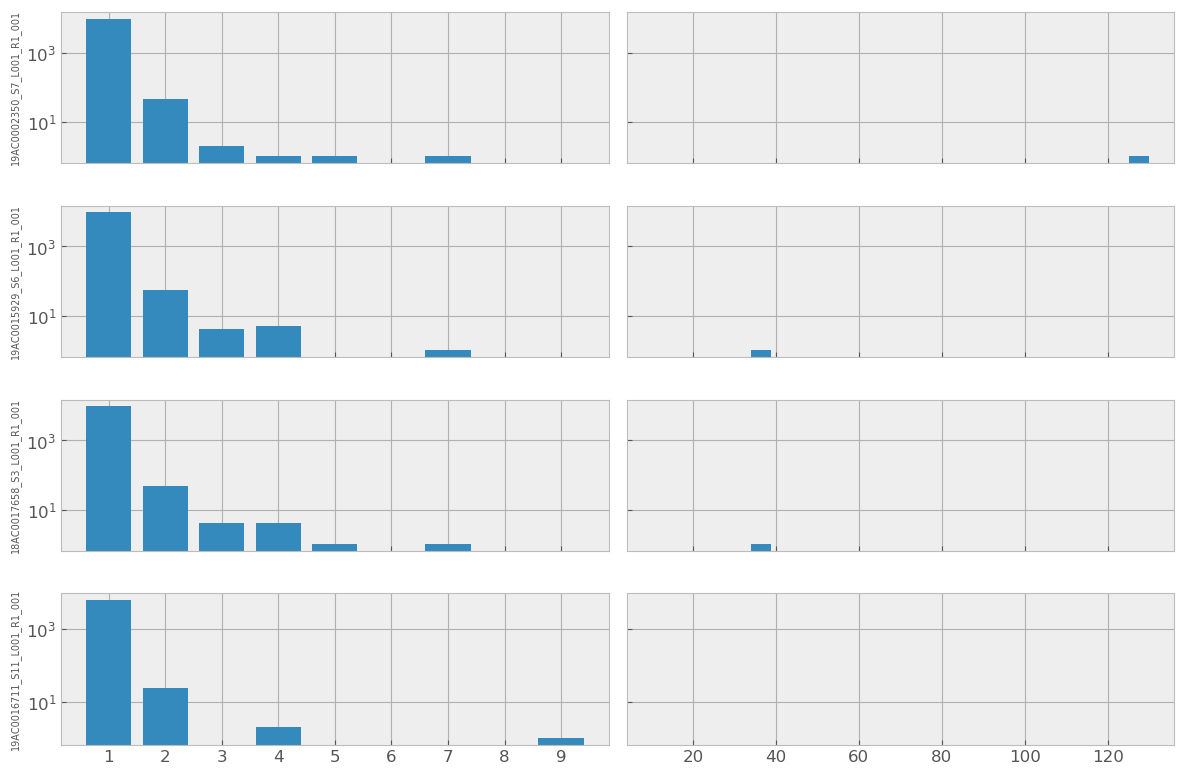

In [19]:
let
    n = 4
    irows = partialsortperm(stats_df[!, :assm_max_kmer_count], 1:4, rev=true)
#     maxcount = stats_df[irows[1], :assm_max_kmer_count]
        
    fig, axs = plt.subplots(n, 2, figsize=(12, 8), sharex=:col, sharey=:row)
    range1 = 1:9
    range2 = (10, 130)
    
    for (i, irow) in enumerate(irows)
        row = stats_df[irow, :]
        key = row[:genome]
        ax1, ax2 = axs[i, :]
        
        h5 = h5open(datafiles[key])
        counts = read(h5, "assembly/counts")
        close(h5)
        
        counts_hist(ax1, counts, range1)
        ax2.hist(counts, range=range2, bins=25)
        
        ax1.set_yscale(:log)
        ax1.set_ylabel(key, fontsize="xx-small")
    end
    
    plt.tight_layout()
end

Seems like just one crazy kmer per genome. Print top 10 for each of these:

In [20]:
let
    ngenomes = 4
    nkmers = 10
    irows = partialsortperm(stats_df[!, :assm_max_kmer_count], 1:ngenomes, rev=true)

    for (i, irow) in enumerate(irows)
        row = stats_df[irow, :]
        key = row[:genome]
        println(key)
        
        h5 = h5open(datafiles[key])
        counts = read(h5, "assembly/counts")
        kmers = Kmer32{11}.(read(h5, "assembly/kmers"))
        close(h5)
        
        for j in partialsortperm(counts, 1:nkmers, rev=true)
            @printf "\t%3d ATGAC%s\n" counts[j] kmers[j]
        end
    end
    
    plt.tight_layout()
end

19AC0002350_S7_L001_R1_001
	126 ATGACTCCAACTTATT
	  7 ATGACTTTCCGTGAGA
	  5 ATGACGTCACAATCTT
	  4 ATGACCTCTCTCGCCT
	  3 ATGACGCCATCGTGGT
	  3 ATGACTTTCCGTGTCA
	  2 ATGACAAAAATGGCGG
	  2 ATGACAAACGCAACAT
	  2 ATGACAATCGACGGCT
	  2 ATGACACAGAATCGGG
19AC0015929_S6_L001_R1_001
	 36 ATGACAAAGTGCCCGT
	  7 ATGACAAAGTGCCCGC
	  4 ATGACAAACCTATTTT
	  4 ATGACAAAGTACCCGT
	  4 ATGACAGTATTTTTAT
	  4 ATGACCTTGTAAATCA
	  4 ATGACTATGTGTAACA
	  3 ATGACAAACCCATTTT
	  3 ATGACAAAGCTGTTGA
	  3 ATGACTTTGGGTATAA
18AC0017658_S3_L001_R1_001
	 36 ATGACAAAGTGCCCGT
	  7 ATGACAAAGTGCCCGC
	  5 ATGACAAACCTATTTT
	  4 ATGACAAAGTACCCGT
	  4 ATGACAGTATTTTTAT
	  4 ATGACCTTGTAAATCA
	  4 ATGACTATGTGTAACA
	  3 ATGACAAACCCATTTT
	  3 ATGACAAAGCTGTTGA
	  3 ATGACTTTGGGTATAA
19AC0016711_S11_L001_R1_001
	  9 ATGACTGAATTGAAAA
	  4 ATGACTAGGATTGAAA
	  4 ATGACTGTACCTCACT
	  2 ATGACAAAGTACAAGC
	  2 ATGACAACAAATAAAA
	  2 ATGACAACACCTTTAT
	  2 ATGACAACAGGATTTA
	  2 ATGACAATGAAATTGA
	  2 ATGACAATTAACAATA
	  2 ATGACAATTGTATTAA


Top kmers for `19AC0015929_S6` and `18AC0017658_S3` are nearly identical. Apparently very closely related samples? I don't know the actual identity.